## Практическое задание к уроку № 6 по теме "Двухуровневые модели рекомендаций."

Подготовим данные, скопировав код с урока:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares

# Модель второго уровня
from xgboost import XGBClassifier

import sys
sys.path.append('../')

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

## Read data

In [2]:
data = pd.read_csv('../../data/retail_train.csv')
item_features = pd.read_csv('../../data/product.csv')
user_features = pd.read_csv('../../data/hh_demographic.csv')

# Process features dataset

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [4]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [5]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [6]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [7]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


# Prefilter items

In [8]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [9]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

# Init/train recommender

In [10]:
recommender = MainRecommender(data_train_matcher)

In [11]:
ACTUAL_COL = 'actual'

In [12]:
result_eval_matcher = data_val_matcher.groupby(USER_COL, sort=False)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,2070,"[1019940, 834103, 918438, 878302, 949616, 9879..."
1,2021,"[840361, 856060, 869344, 896862, 951590, 10191..."


In [13]:
def calc_recall(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [14]:
def calc_precision(df_result, top_k):
    for col_name in df_result.columns[2:]:
        yield col_name, df_result.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### **Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


Создадим кандидатов:

In [15]:
def make_recommendations(df_result, rec_name_model, N=50):
    rec_name = rec_name_model[0]
    rec_model = rec_name_model[1]
    df_result[rec_name] = df_result[USER_COL].apply(lambda x: rec_model(x, N=N))

In [16]:
own_rec = ('own_recs', recommender.get_own_recommendations)
als_rec = ('als_recs', recommender.get_als_recommendations)
sim_user_rec = ('similar_user_recs', recommender.get_similar_users_recommendation)
sim_item_rec = ('similar_item_recs', recommender.get_similar_items_recommendation)

In [17]:
for rec in (own_rec, als_rec, sim_user_rec, sim_item_rec):
    make_recommendations(result_eval_matcher, rec, N=50)

Также сделаем смесь own_recommendations и top-popular:

In [18]:
make_recommendations(result_eval_matcher, ('own+top_pop', recommender.get_own_recommendations), N=25)

In [19]:
def fill_with_tops(column, N=5):
    
    tops = np.array(recommender.overall_top_purchases)
    recs = np.array(column)
    mask = np.isin(tops, recs, invert=True)
    tops = tops[mask]
    
    return np.append(recs, tops[:N])

In [20]:
result_eval_matcher['own+top_pop'] = result_eval_matcher['own+top_pop']. \
        apply(lambda row: fill_with_tops(row, N=25))

In [21]:
len(result_eval_matcher.iloc[0]['own+top_pop'])

50

Посмотрим на recall@50 кандидатов, полученных разными способами:

In [22]:
sorted(calc_recall(result_eval_matcher, 50), key=lambda x: x[1], reverse=True)

[('own_recs', 0.07934879656918649),
 ('own+top_pop', 0.0738710471311752),
 ('als_recs', 0.048092753849589144),
 ('similar_item_recs', 0.032414477233487456),
 ('similar_user_recs', 0.025494293767761935)]

Наибольший recall@50 показали кандидаты, созданные по принципу  
own_recomendations. Это неудивительно, так как они формировались  
по принципу максимальной похожести на только одного ближайшего  
"соседа". С учётом отсутствия фильтрации по уже совершённым покупкам,  
в кандидатах зачастую оказываются фактические покупки.  
Подмешивание в этих кандидатов топ-популярных не дало повышения recall.

Теперь оценим метрику recall@k при различных значениях k.  
За основу возьмём own_recommend способ формирования кандидатов:

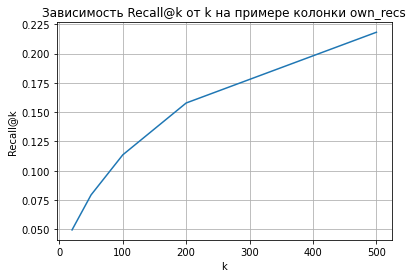

In [23]:
ks = (20, 50, 100, 200, 500)
scores = []

TEST_COL = 'own_recs'

for k in ks:
    make_recommendations(result_eval_matcher, own_rec, N=k)
    scores.append(result_eval_matcher.apply(lambda row: recall_at_k(row[TEST_COL], row[ACTUAL_COL], k=k), axis=1).mean())

plt.plot(ks, scores)
plt.xlabel('k')
plt.ylabel('Recall@k')
plt.title(f'Зависимость Recall@k от k на примере колонки {TEST_COL}')
plt.grid()
plt.show()

Как видно из графика, с увеличением k метрика повышается  
всё более полого. Это говорит о том, что с увеличением  
количества кандидатов их качество падает. Поэтому нет  
особого смысла отправлять на ранжирование сотни кандидатов,  
т.к. это будет дополительная нагрузка для модели, а выдавать  
пользователю мы всё равно будем не так много рекомендаций.  
Если у нас, например, какая-нибудь поисковая выдача, где мы  
выдаём много рекомендаций, то после 100-й рекомендации можно  
уже выдавать неотранжированных кандидатов, всё равно мало кто  
пролистает столько страниц.  
Таким образом, для выдачи в ретейле считаю 50 оптимальным значением  
для количества кандидатов на ранжирование. В случае поисковой выдачи  
можно поднять это значение до 100.

### **Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

Сначала измерим precision@5 имеющихся кандидатов:

In [24]:
sorted(calc_precision(result_eval_matcher, 5), key=lambda x: x[1], reverse=True)

[('own_recs', 0.2242565055762082),
 ('own+top_pop', 0.2242565055762082),
 ('als_recs', 0.09433085501858736),
 ('similar_item_recs', 0.06282527881040893),
 ('similar_user_recs', 0.02732342007434944)]

## Подготовка данных для трейна

In [25]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

Кандидатов будем отбирать методом ALS для разнообразия:

In [26]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

In [27]:
df_match_candidates.head(3)

,user_id,candidates
0,2070,"[1107553, 1042942, 9526410, 879755, 9527290, 8..."
1,2021,"[981521, 12731544, 1013928, 1009333, 1019142, ..."
2,1753,"[1110572, 926422, 991951, 861445, 879755, 1037..."


Разворачиваем кандидатов, чтобы в каждой строке был только один:

In [28]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [29]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [30]:
df_match_candidates.head()

,user_id,item_id
0,2070,1107553
0,2070,1042942
0,2070,9526410
0,2070,879755
0,2070,9527290


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 

In [31]:
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 

In [32]:
df_ranker_train

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1
...,...,...,...
2282320,222,1120741,1
2282321,462,993339,1
2282322,462,995242,1
2282323,462,10180324,1


Добавляем кандитатов в датасет в качестве нулей:

In [33]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

Посмотрим на баланс классов:

In [34]:
df_ranker_train.target.value_counts()

0.0    101469
1.0      6131
Name: target, dtype: int64

In [35]:
df_ranker_train

,user_id,item_id,target
0,2070,1107553,0.0
1,2070,1042942,0.0
2,2070,9526410,0.0
3,2070,879755,0.0
4,2070,9527290,0.0
...,...,...,...
110177,1745,969205,0.0
110178,1745,5585510,0.0
110179,1745,1071171,0.0
110180,1745,948832,0.0


In [36]:
df_ranker_train['target'].mean()

0.05697955390334573

## Подготавливаем фичи для обучения модели

In [37]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [38]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [39]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


**Фичи user_id:**
    - Средний чек
    - Средняя сумма покупки 1 товара в каждой категории
    - Кол-во покупок в каждой категории
    - Частотность покупок раз/месяц
    - Долю покупок в выходные
    - Долю покупок утром/днем/вечером

**Фичи item_id**:
    - Кол-во покупок в неделю
    - Среднее кол-во покупок 1 товара в категории в неделю
    - (Кол-во покупок в неделю) / (Среднее ол-во покупок 1 товара в категории в неделю)
    - Цена (Можно посчитать из retil_train.csv)
    - Цена / Средняя цена товара в категории
    
**Фичи пары user_id - item_id**
    - (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    - (Кол-во покупок юзером конкретной категории в неделю) - (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)
    - (Кол-во покупок юзером конкретной категории в неделю) / (Среднее кол-во покупок всеми юзерами конкретной категории в неделю)

#### Фичи user_id

In [40]:
# Средний чек
df_ranker_train = df_ranker_train.merge(data_train_matcher.groupby(USER_COL, sort=False)['sales_value']. \
                                    mean().reset_index(), how='left', on=USER_COL)
df_ranker_train.rename(columns={'sales_value': 'avg_bill'}, inplace=True)

In [41]:
# Средняя сумма покупки 1 товара в каждой категории
data_train_matcher = data_train_matcher.merge(item_features[[ITEM_COL, 'department']], how='left', on=ITEM_COL)
df_ranker_train = df_ranker_train.merge(data_train_matcher.groupby([USER_COL, 'department'], sort=False)['sales_value'] \
                                        .mean().reset_index(), how='left', on=[USER_COL, 'department']). \
                                        rename(columns={'sales_value': 'avg_cat_spendings'})

In [42]:
df_ranker_train.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,avg_cat_spendings
0,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977
1,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977
2,2070,9526410,0.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977


#### Фичи item_id

In [43]:
# Кол-во покупок в неделю
df_ranker_train = df_ranker_train.merge((data_train_matcher.groupby(ITEM_COL, sort=False)['quantity'] \
                                         .count() / data_train_matcher['week_no'].nunique()).reset_index(), how='left', on=ITEM_COL)

df_ranker_train.rename(columns={'quantity': 'avg_week_purchases'}, inplace=True)

In [44]:
# Среднее кол-во покупок 1 товара в категории в неделю
df_ranker_train = df_ranker_train.merge((data_train_matcher.groupby('department', sort=False)['quantity'] \
                                         .count() / data_train_matcher['week_no'].nunique()).reset_index(), \
                                        how='left', on='department').rename(columns={'quantity': 'avg_week_purchases_cat'})

In [45]:
df_ranker_train.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,avg_cat_spendings,avg_week_purchases,avg_week_purchases_cat
0,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,9.035294,7342.223529
1,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,3.282353,7342.223529
2,2070,9526410,0.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,20.870588,7342.223529


#### Фичи пары user_id - item_id

In [46]:
# Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)
df_ranker_train = df_ranker_train.merge(data_train_matcher.groupby('department', sort=False)['sales_value'] \
                                         .mean().reset_index(), how='left', on='department') \
                                         .rename(columns={'sales_value': 'avg_cat_spendings_items'})

In [47]:
# Кол-во покупок юзером конкретной категории в неделю
df_ranker_train = df_ranker_train.merge((data_train_matcher.groupby([USER_COL, 'department'], sort=False)['quantity'] \
                                         .count() / data_train_matcher['week_no'].nunique()).reset_index(), how='left', \
                                        on=[USER_COL, 'department']).rename(columns={'quantity': 'user_week_cat_purchase'})

In [48]:
df_ranker_train.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,avg_bill,avg_cat_spendings,avg_week_purchases,avg_week_purchases_cat,avg_cat_spendings_items,user_week_cat_purchase
0,2070,1107553,0.0,103,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,9.035294,7342.223529,2.635412,6.094118
1,2070,1042942,0.0,69,GROCERY,Private,ICE CREAM/MILK/SHERBTS,PAILS,4 QT,45-54,...,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,3.282353,7342.223529,2.635412,6.094118
2,2070,9526410,0.0,544,GROCERY,National,BAG SNACKS,POTATO CHIPS,11.5 OZ,45-54,...,Unknown,Unknown,1,None/Unknown,3.562354,2.523977,20.870588,7342.223529,2.635412,6.094118


Подготовим датасеты для обучения модели:

In [49]:
X_train = df_ranker_train.iloc[:, 2:].drop('target', axis=1)
y_train = df_ranker_train['target']

Выделим категориальные признаки для дальнейшей обработки:

In [50]:
cat_feats = X_train.columns.tolist()[:-6]
X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

Посмотрим на количество пропущенных значений:

In [51]:
X_train.isna().sum()

manufacturer                   0
department                     0
brand                          0
commodity_desc                 0
sub_commodity_desc             0
curr_size_of_product           0
age_desc                   68050
marital_status_code        68050
income_desc                68050
homeowner_desc             68050
hh_comp_desc               68050
household_size_desc        68050
kid_category_desc          68050
avg_bill                       0
avg_cat_spendings           2729
avg_week_purchases             0
avg_week_purchases_cat         0
avg_cat_spendings_items        0
user_week_cat_purchase      2729
dtype: int64

Заполним пропуски модой, параллельно будем создавать новый признак,  
фиксирующий факт того, что значение в столбце было изменено:

In [52]:
nan_cols = X_train.isna().sum().loc[X_train.isna().sum() > 0].index.tolist()

for col in nan_cols:
    X_train[f'{col}_nan'] = 0
    X_train.loc[X_train[col].isna(), f'{col}_nan'] = 1
    X_train[col].fillna(X_train[col].value_counts().index[0], inplace=True)

In [53]:
X_train.isna().sum().sum()

0

## Обучение модели ранжирования

Закодируем категориальные признаки:

In [54]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train = X_train.drop(cat_feats, axis=1).join(pd.DataFrame(encoder.fit_transform(X_train[cat_feats]), \
                                                            columns=encoder.get_feature_names_out(cat_feats)))

Обучим классификатор и посмотрим на предсказания:

In [55]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=200, silent=True,
                           eta=0.1, task_type='GPU',
                           auto_class_weights='Balanced',
                           random_state=29
            )
model.fit(X_train, y_train)

train_preds = model.predict_proba(X_train)

In [56]:
df_ranker_predict = df_ranker_train.copy()

In [57]:
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]

In [58]:
df_ranker_predict['proba_item_purchase'][:10]

0    0.719326
1    0.623822
2    0.237627
3    0.771141
4    0.235181
5    0.714822
6    0.671295
7    0.866600
8    0.692142
9    0.777229
Name: proba_item_purchase, dtype: float64

## Оценка на валидационном датасете

На валидации присутствуют пользователи, которых не было на трейне:

In [59]:
data_val_ranker.loc[~data_val_ranker[USER_COL].isin(data_train_ranker[USER_COL])][USER_COL].nunique()

126

Таким образом, способ, которым мы пользовались на уроке (использование предсказаний  
на трейне для ранжирования на валидации), нам не подходит, так как функция ранжирования  
будет возвращать пустой список в случаях, когда встречается user_id, которого не было  
на трейне.  
Поэтому напишем класс, который будет подготавливать датасет для модели. Будем использовать  
его, чтобы подготовить валидационный датасет, и на нём делать предсказание модели. По сути,  
обернём в класс то, что писали ранее для трейна:

In [60]:
class ValDataProcessor:
    
    def __init__(self):
        self.cat_feats = None
        self.data_train_ranker = None
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
        self.item_features = None
        self.nan_cols = None
        self.train_data = None
        self.user_features = None
        
    # Добавление фичей
    def _add_features(self, df, is_fit=True):
        
        # Первоначальная подготовка
        df = df[[USER_COL, ITEM_COL]].copy()
        df = df.merge(self.item_features, on=ITEM_COL, how='left')
        df = df.merge(self.user_features, on=USER_COL, how='left')
        
        # Средний чек
        df = df.merge(self.train_data.groupby(USER_COL, sort=False)['sales_value']. \
                                    mean().reset_index(), how='left', on=USER_COL)
        df.rename(columns={'sales_value': 'avg_bill'}, inplace=True)
        
        # Средняя сумма покупки 1 товара в каждой категории
        df = df.merge(self.train_data.groupby([USER_COL, 'department'], sort=False)['sales_value'] \
                                                .mean().reset_index(), how='left', on=[USER_COL, 'department']). \
                                                rename(columns={'sales_value': 'avg_cat_spendings'})
        
        # Кол-во покупок в неделю
        df = df.merge((self.train_data.groupby(ITEM_COL, sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), how='left', on=ITEM_COL)

        df.rename(columns={'quantity': 'avg_week_purchases'}, inplace=True)
        
        # Среднее кол-во покупок 1 товара в категории в неделю
        df = df.merge((self.train_data.groupby('department', sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), \
                                                how='left', on='department').rename(columns={'quantity': 'avg_week_purchases_cat'})
        
        # Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)
        df = df.merge(self.train_data.groupby('department', sort=False)['sales_value'] \
                                                 .mean().reset_index(), how='left', on='department') \
                                                 .rename(columns={'sales_value': 'avg_cat_spendings_items'})
        
        # Кол-во покупок юзером конкретной категории в неделю
        df = df.merge((self.train_data.groupby([USER_COL, 'department'], sort=False)['quantity'] \
                                                 .count() / self.train_data['week_no'].nunique()).reset_index(), how='left', \
                                                on=[USER_COL, 'department']).rename(columns={'quantity': 'user_week_cat_purchase'})
        
        # Подготовка
        df = df.iloc[:, 2:]
        self.cat_feats = df.columns.tolist()[:-6]
        df[self.cat_feats] = df[self.cat_feats].astype('category')
        
        # Заполнение пропусков модой
        if not is_fit:
            self.nan_cols = df.isna().sum().loc[df.isna().sum() > 0].index.tolist()

        for col in self.nan_cols:
            df[f'{col}_nan'] = 0
            df.loc[df[col].isna(), f'{col}_nan'] = 1
            
            if is_fit:
                data_source = self.data_train_ranker.copy()
            else:
                data_source = df.copy()
                
            df[col].fillna(data_source[col].value_counts().index[0], inplace=True)
        
        # В случае появления новых item_id будут появляться пропуски в столбцах,
        # в которых не было пропусков на трейне. Обработаем их отдельно, чтобы не  
        # менять количество признаков
        additional_nans = df.isna().sum().loc[df.isna().sum() > 0].index.tolist()
        
        for col in additional_nans:
            df[col].fillna(data_source[col].value_counts().index[0], inplace=True)
        
        if not is_fit:
            self.encoder.fit(df[self.cat_feats])
        
        return df
        
        
    def fit(self, data_train_ranker, train_data, user_features, item_features):
        self.data_train_ranker = data_train_ranker
        self.train_data = train_data
        self.user_features = user_features
        self.item_features = item_features

        # Добавим фичи на трейне, чтобы были данные для заполнения пропусков
        # на валидации, и заодно обучим OHEncoder
        self.data_train_ranker = self._add_features(self.data_train_ranker, is_fit=False)
        
    
    def transform(self, X):
        
        X = self._add_features(X)

        # Сделаем OHE, при этом чтобы на выходе получился красивый датасет
        X = X.drop(self.cat_feats, axis=1).join(pd.DataFrame(self.encoder.transform(X[self.cat_feats]), \
                                                    columns=self.encoder.get_feature_names_out(self.cat_feats)))

        return X

Проверим работу класса, посмотрим на размер трейна после наших  
предыдущих преобразований и сравним его с результатом работы класса:

In [61]:
X_train.shape

(107600, 2267)

In [62]:
processor = ValDataProcessor()
processor.fit(df_ranker_train, data_train_matcher, user_features, item_features)
X_train = processor.transform(df_ranker_train)

In [63]:
X_train.shape

(107600, 2267)

Класс вернул нам датасет такого же размера, значит  
всё работает корректно, и датасет будет понятен модели  
для предсказания.

Создадим датасет с фактическими покупками на валидации:

In [64]:
result_eval_ranker = data_val_ranker.groupby(USER_COL, sort=False)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]
result_eval_ranker.head(2)

,user_id,actual
0,338,"[840173, 1037348, 5592737, 7441679, 7442317, 1..."
1,2120,"[441768, 480433, 492628, 503227, 525168, 52575..."


Создадим кандидатов для валидационного датасета:

In [65]:
%%time
result_eval_ranker['als_rec'] = result_eval_ranker[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=50))

CPU times: user 2min 21s, sys: 2min 20s, total: 4min 41s
Wall time: 23.7 s


Посмотрим на метрику, чтобы было с чем сравнить результат работы  
модели ранжирования:

In [66]:
sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True)

[('als_rec', 0.07800097991180795)]

Выделим отдельно датасет с кандидатами и развернём его, как делали  
ранее с трейном:

In [67]:
df_match_candidates = result_eval_ranker.copy().rename(columns={'als_rec': 'candidates'}).drop(ACTUAL_COL, axis=1)

In [68]:
df_match_candidates.head(3)

,user_id,candidates
0,338,"[845208, 871611, 1037863, 934639, 1084036, 896..."
1,2120,"[1110843, 1124029, 1076056, 823862, 983078, 98..."
2,2324,"[942778, 893501, 970119, 910151, 954673, 88188..."


In [69]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = ITEM_COL

In [70]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [71]:
df_match_candidates.head()

,user_id,item_id
0,338,845208
0,338,871611
0,338,1037863
0,338,934639
0,338,1084036


Подготовим датасет из кандидатов для предсказания:

In [72]:
X_valid = processor.transform(df_match_candidates)

In [73]:
X_valid.shape

(102050, 2267)

Сделаем предсказание:

In [74]:
val_preds = model.predict_proba(X_valid)

In [75]:
df_match_candidates['proba_item_purchase'] = val_preds[:, 1]

In [76]:
df_match_candidates.head(3)

,user_id,item_id,proba_item_purchase
0,338,845208,0.823019
0,338,871611,0.561956
0,338,1037863,0.737928


Функция для ранжирования кандидатов по вероятности:

In [77]:
def rerank(user_id):
    return df_match_candidates[df_match_candidates[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

Сделаем ранжирование:

In [78]:
result_eval_ranker['reranked_als_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

Оценим метрику:

In [79]:
print(*sorted(calc_precision(result_eval_ranker, 5), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_als_rec', 0.10720235178833903)
('als_rec', 0.07800097991180795)


In [80]:
result_eval_ranker.head(3)

,user_id,actual,als_rec,reranked_als_rec
0,338,"[840173, 1037348, 5592737, 7441679, 7442317, 1...","[845208, 871611, 1037863, 934639, 1084036, 896...","[845208, 1037863, 1026118, 1051516, 1028816]"
1,2120,"[441768, 480433, 492628, 503227, 525168, 52575...","[1110843, 1124029, 1076056, 823862, 983078, 98...","[1110843, 1026118, 961979, 1007136, 5585510]"
2,2324,"[1027569, 1051069, 12487286, 6443300, 865907, ...","[942778, 893501, 970119, 910151, 954673, 88188...","[1136257, 893501, 901062, 916993, 987724]"


<ins>Вывод:</ins> использование модели классификации для ранжирования кандидатов   
позволило поднять точность рекомендаций.